In [1]:
import ray.tune
from pathlib import Path
from dataclasses import dataclass, field
from functools import lru_cache
import pandas as pd
from typing import List, Tuple
from functools import partial
import seaborn as sns

In [2]:
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

In [3]:
from etr_fr_expes import metric

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ledoyen202/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
EXPE_DIR = Path("../../experimentations/").resolve()
ICL_EXPE_DIR = EXPE_DIR / "icl_experimentations"

In [5]:
MBARTHEZ, MBART, MISTRAL, LLAMA3 = "mbarthez", "mbart", "mistral", "llama3"
MISTRAL_INSTRUCT, LLAMA_INSTRUCT = "mistral-7b", "llama3-8b"

DEEPSEEK = "deepseekr1"
LORA, MTLLORA = "lora", "mtllora"
ZERO_SHOT = "zero_shot"
RAG = "rag"
ETR_FR, ORANGESUM, WIKILARGE, ETR_FR_ORANGESUM, ETR_FR_WIKILARGE, ALL = "etrfr", "orangesum", "wikilarge", "etrfr+orangesum", "etrfr+wikilarge", "etrfr+orangesum+wikilarge"

In [6]:
ETRMetrics = metric.ETRMetrics("fr")

In [7]:
@dataclass
class Expe:
    model: str
    method: str
    task: str
    train_tasks: str
    metric: str
    mode: str
    adapter_name: str
    model_name: str = None
    split: str = "eval"
    expe_dir: str = EXPE_DIR
    step: str = "hp_search"
    _expe_analysis = None
    
    
    @property
    def base_columns(self):
        return [
            # "expe",
            "trial_id",
            "model", 
            "method", 
            "task", 
            "train_tasks", 
            # "metric",
        ]
    
    @property
    def selection_metric(self):
        return f"{self.split}_{self.metric}"
    
    @property
    def expe_name(self):
        return f"{self.model}.{self.method}.{self.train_tasks}"
    
    @property
    def expe_analysis(self):
        step = f"_{self.step}" if self.step else ""
        hp_search_dir = self.expe_dir / self.expe_name / "results" / f"{self.expe_name}{step}"
        if self._expe_analysis is None:
            self._expe_analysis = ray.tune.ExperimentAnalysis(hp_search_dir)
        return self._expe_analysis
    
    @property
    def dfs(self):
        return self.expe_analysis.trial_dataframes

    @property
    def dataframe(self):
        dfs = self.dfs
        res = (pd.concat(dfs, ignore_index=True)
            .reset_index(level=0)
            .assign(
                expe=self.expe_name, 
                model=self.model_name or self.model, 
                metric=self.metric,
                method=self.method,
                task=self.task,
                train_tasks=self.train_tasks,
            )
            .sort_values(by=f"{self.split}_{self.metric}", ascending=self.mode == "min")
            .rename(columns=lambda x: x.replace(self.adapter_name, 'adapter'))
        )
        res = res.set_index(self.base_columns)
        return res
    
    def metric_columns(self, _type="test"):
        return self.dataframe.filter(
            regex=f"{_type}_{self.task}_(?!texts)"
        ).columns
        
    def text_columns(self, _type="test"):
        return self.dataframe.filter(
            regex=f"{_type}.*texts"
        ).columns
        
    @property
    def test_metric_df(self):
        return self.dataframe[self.metric_columns(_type="test")]
    
    @property
    def eval_metric_df(self):
        return self.dataframe[self.metric_columns(_type="eval")]
    
    @property
    def best_model(self):
        return self.dataframe.iloc[0]
    
    def get_texts_df(self, row_idx, _type="test"):
        row_df = self.dataframe.iloc[row_idx].filter(regex=f"{_type}.*texts").to_frame().T
        row_df = row_df.explode(list(row_df.columns)).reset_index(drop=True).stack().to_frame()
        return row_df
    
    @property
    def best_trial(self):
        return self.expe_analysis.get_best_trial(metric=self.metric, mode=self.mode, scope="all")
    
@dataclass
class RAGExpe(Expe):
    
    @property
    def dfs(self):
        return [self.expe_analysis.dataframe()]
    
    def get_best_df(self, df):
        best_idx = df[self.selection_metric].idxmax()
        config_columns = list(df.filter(regex="icl_config").columns)
        best_config = df.loc[best_idx, config_columns]
        
        def is_same_config(row):
            return all((a == b) or (pd.isna(a) and pd.isna(b)) for a, b in zip(row[config_columns], best_config))

        return df[df.apply(is_same_config, axis=1)]
        
    @property
    def dataframe(self):
        res = super().dataframe
        res = self.get_best_df(res)
        return res
    
    
ETRFrExpe = partial(Expe, metric="etr_fr_srb", mode="max", task="etr_fr", adapter_name="lora_etr_fr")
RAGETRFrExpe = partial(RAGExpe, metric="etr_fr_srb", mode="max", task="etr_fr", adapter_name="lora_etr_fr")

OrangesumExpe = partial(Expe, metric="orangesum_rougeL", mode="max", task="orangesum", adapter_name="lora_orangesum")
WikilargeExpe = partial(Expe, metric="wikilarge_fr_sari", mode="max", task="wikilarge_fr")

In [233]:
@dataclass
class Analysis:
    expes: List['Expe']
    metrics: List[str] = field(default_factory=lambda: [
        "rouge1",
        "rouge2",
        "rougeL",
        "sari",
        "bertscore_f1",
        # "srb",
        "compression_ratio",
        "novelty",
        # "kmre",
        # "lix"
    ])

    model_order: List[str] = field(default_factory=lambda :[
        MISTRAL_INSTRUCT, 
        LLAMA_INSTRUCT,
        MBARTHEZ, 
        LLAMA3, 
        MISTRAL,
    ])
    tasks_order: List[Tuple[str, str]] = field(default_factory=lambda :[
        (RAG, ETR_FR),
        (RAG, ETR_FR_ORANGESUM),
        (RAG, ETR_FR_WIKILARGE),
        (RAG, ALL),
        
        
        (LORA, ETR_FR),
        (MTLLORA, ETR_FR_ORANGESUM),
        (MTLLORA, ETR_FR_WIKILARGE),
        (MTLLORA, ALL),
        
    ])
        

    def _sort_df_by_model_and_tasks(self, df):
        model_map = {k: i for i, k in enumerate(self.model_order)}
        tasks_map = {k: i for i, k in enumerate(self.tasks_order)}

        index_df = pd.DataFrame(df.index.tolist(), columns=['model', 'adapter', 'tasks'])

        index_df['model_order'] = index_df['model'].map(model_map)
        index_df['tasks_tuple'] = list(zip(index_df['adapter'], index_df['tasks']))
        index_df['tasks_order'] = index_df['tasks_tuple'].map(tasks_map)

        sorted_index = pd.MultiIndex.from_frame(
            index_df.sort_values(['model_order', 'tasks_order']).drop(columns=['model_order', 'tasks_order', 'tasks_tuple'])
        )

        return df.reindex(sorted_index)

    def _standardize_column_multiindex(self, df, groups=None, separator="_"):
        if groups is None:
            groups = []

        groups = sorted(groups, key=len, reverse=True)

        new_cols = []
        for metric, stat in df.columns:
            matched_group = "other"
            short_name = metric

            for group in groups:
                if metric.startswith(group + separator):
                    matched_group = group
                    short_name = metric[len(group) + 1:]
                    break

            new_cols.append((matched_group, short_name, stat))

        df.columns = pd.MultiIndex.from_tuples(new_cols, names=['group', 'metric', 'stat'])
        return df

    def _format_mean_std_with_bold(self, df: pd.DataFrame, global_max_idx) -> pd.DataFrame:
        """
        Format mean ± std as LaTeX, and bold the best (max) mean per (group, metric).
        """
        # Ensure it's a MultiIndex with a 'stat' level
        if 'stat' not in df.columns.names:
            raise ValueError("Expected MultiIndex columns with 'stat' level")

        mean = df.xs('mean', level='stat', axis=1)
        std = df.xs('std', level='stat', axis=1)

        # Determine the max mean index per column
        max_idx = mean.idxmax()

        # Build formatted DataFrame
        formatted = pd.DataFrame(index=mean.index, columns=mean.columns)

        for col in mean.columns:
            for idx in mean.index:
                m = mean.at[idx, col]
                s = std.at[idx, col]

                bf = idx == global_max_idx[col]
                underl = idx == max_idx[col]

                # if bf and underl:
                #     formatted.at[idx, col] = f"$\\underline{{\\mathbf{{{m:.2f}}}}}_{{\\pm{s:.2f}}}$"
                if bf:
                    formatted.at[idx, col] = f"$\\mathbf{{{m:.2f}}}_{{\\pm{s:.2f}}}$"
                elif underl:
                    formatted.at[idx, col] = f"$\\underline{{{m:.2f}}}_{{\\pm{s:.2f}}}$"
                else:
                    formatted.at[idx, col] = f"${m:.2f}_{{\\pm{s:.2f}}}$"
        return formatted

    def reorder_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        """Reorders and filters MultiIndex columns by desired metrics. Supports 2 or 3 levels."""
        desired_order = self.metrics
        order_map = {metric: i for i, metric in enumerate(desired_order)}

        if isinstance(df.columns, pd.MultiIndex):
            num_levels = df.columns.nlevels

            if num_levels == 3:
                filtered_columns = [col for col in df.columns if col[1] in order_map]
                sorted_columns = sorted(filtered_columns, key=lambda col: (
                    col[0], order_map[col[1]], col[2]
                ))
            elif num_levels == 2:
                filtered_columns = [col for col in df.columns if col[1] in order_map]
                sorted_columns = sorted(filtered_columns, key=lambda col: (
                    col[0], order_map[col[1]]
                ))
            else:
                raise ValueError("Unsupported column MultiIndex depth.")

            return df[sorted_columns]

        else:
            # Not a MultiIndex – optionally filter if plain column names match metrics
            filtered_columns = [col for col in df.columns if col in order_map]
            sorted_columns = sorted(filtered_columns, key=lambda col: order_map[col])
            return df[sorted_columns]
        
    def set_task_level(self, df):
        new_tuples = []
        for model, adapter, task_str in df.index:
            task_set = set(task_str.split('+'))
            has_etrfr = 'etrfr' in task_set
            has_orangesum = 'orangesum' in task_set
            has_wikilarge = 'wikilarge' in task_set
            new_tuples.append((model, adapter, has_etrfr, has_orangesum, has_wikilarge))

        # Create MultiIndex
        new_index = pd.MultiIndex.from_tuples(
            new_tuples,
            names=['model', 'adapter', 'etrfr', 'orangesum', 'wikilarge']
        )
        df.index = new_index
        return df
    
    @property
    def dataframe(self):
        dfs = [expe.dataframe for expe in self.expes]
        return pd.concat(dfs)

    def best_models(self, _type=None, texts=False):
        series = [expe.best_model for expe in self.expes]
        res = pd.DataFrame(series)

        return_metrics = _type in ["test", "eval"]
        if not texts and return_metrics:
            res = res.filter(regex=f"{_type}.*({'|'.join(self.metrics)})")
        elif return_metrics:
            cols = self.expes[0].text_columns(_type=_type)
            res = res[cols]

        return res

    def mean_models(self, _type="test", texts=False):
        res = self.dataframe

        return_metrics = _type in ["test", "eval"]
        if not texts and return_metrics:
            res = res.filter(regex=f"{_type}.*({'|'.join(self.metrics)})")
        elif return_metrics:
            cols = self.expes[0].text_columns(_type=_type)
            res = res[cols]

        res = (res
               .groupby(["model", "method", "train_tasks"])
               .agg(['mean', 'std'])
               .round(2)
        )

        res = self._sort_df_by_model_and_tasks(res)
        res = self._standardize_column_multiindex(res, groups=["test_etr_fr_politic", "test_etr_fr"])
        
        global_max_idx = res.xs('mean', level='stat', axis=1).idxmax()
        res = res.groupby(level="model", sort=False).apply(lambda x: self._format_mean_std_with_bold(x, global_max_idx))
        res = self.reorder_metrics(res)
        res = res.droplevel(0)
        # res = self.set_task_level(res)

        return res

    @property
    def test_metrics(self):
        return self.best_models(_type="test")

    @property
    def eval_metrics(self):
        return self.best_models(_type="eval")

    @property
    def test_texts(self):
        return self.best_models(_type="test", texts=True)
    
    def get_text_df(self, test_set):
        def get_idx_or_first(group):
            if group.notna().any():
                return group.idxmax()
            else:
                return group.index[0]

        df = self.dataframe
        idx = df.groupby(
            level=["model", "method", "task", "train_tasks"]
        )["eval_etr_fr_srb"].apply(get_idx_or_first)

        df = df.loc[idx]

        res = pd.DataFrame({
            **{"test_set": test_set},
            **{f"{col}": df.iloc[0].loc[f"{test_set}_texts/{col}"] for col in ("inputs", "labels")},
        })
        gens = df[f"{test_set}_texts/predictions"].to_frame().T.droplevel(["task", "trial_id"], axis=1)
        gens = gens.explode(gens.columns.to_list()).reset_index(drop=True)
        res = pd.concat([res, gens], axis=1)
        return res


In [234]:
etr_fr_analysis = Analysis(
    expes=[        
        ETRFrExpe(model=MBARTHEZ, method=LORA, train_tasks=ETR_FR),
        ETRFrExpe(model=MBARTHEZ, method=MTLLORA, train_tasks=ALL),
        ETRFrExpe(model=MBARTHEZ, method=MTLLORA, train_tasks=ETR_FR_ORANGESUM),
        ETRFrExpe(model=MBARTHEZ, method=MTLLORA, train_tasks=ETR_FR_WIKILARGE),
        
        ETRFrExpe(model=LLAMA3, method=LORA, train_tasks=ETR_FR),
        ETRFrExpe(model=LLAMA3, method=MTLLORA, train_tasks=ALL),
        ETRFrExpe(model=LLAMA3, method=MTLLORA, train_tasks=ETR_FR_ORANGESUM),
        ETRFrExpe(model=LLAMA3, method=MTLLORA, train_tasks=ETR_FR_WIKILARGE),
        
        ETRFrExpe(model=MISTRAL, method=LORA, train_tasks=ETR_FR),
        ETRFrExpe(model=MISTRAL, method=MTLLORA, train_tasks=ALL),
        ETRFrExpe(model=MISTRAL, method=MTLLORA, train_tasks=ETR_FR_ORANGESUM),
        ETRFrExpe(model=MISTRAL, method=MTLLORA, train_tasks=ETR_FR_WIKILARGE),
        
        ETRFrExpe(model=DEEPSEEK, method=LORA, train_tasks=ETR_FR),
        ETRFrExpe(model=DEEPSEEK, method=MTLLORA, train_tasks=ALL),
        ETRFrExpe(model=DEEPSEEK, method=MTLLORA, train_tasks=ETR_FR_ORANGESUM),
        ETRFrExpe(model=DEEPSEEK, method=MTLLORA, train_tasks=ETR_FR_WIKILARGE),
    ]
)

wikilarge_analysis = Analysis(
    expes=[
        WikilargeExpe(model=MBARTHEZ, method=LORA, train_tasks="wikilarge-fr", adapter_name="lora_wikilarge_fr"),
        WikilargeExpe(model=LLAMA3, method=LORA, train_tasks=WIKILARGE, adapter_name="lora_wikilarge"),
        WikilargeExpe(model=MISTRAL, method=LORA, train_tasks=WIKILARGE, adapter_name="lora_wikilarge"),
    ]
)

orangesum_analysis = Analysis(
    expes=[
        OrangesumExpe(model=MBARTHEZ, method=LORA, train_tasks=ORANGESUM),
        OrangesumExpe(model=LLAMA3, method=LORA, train_tasks=ORANGESUM),
        OrangesumExpe(model=MISTRAL, method=LORA, train_tasks=ORANGESUM),
    ]
)



In [235]:
# etr_fr_analysis.eval_metrics

In [236]:
# etr_fr_analysis.test_metrics

In [237]:
# ETRMetrics.compute?

In [238]:
# import numpy as np

In [239]:
def compute_metrics(text_df, n_examples):
    text_df = text_df.unstack().droplevel(0, axis=1)
    text_df.columns = text_df.columns.str.split('/').str[-1]
    return (text_df
     .apply(
        lambda x: ETRMetrics([x.predictions], [x.labels], [x.inputs]),
        axis=1,
        result_type='expand'
     ).iloc[:n_examples]
    )

In [240]:
def bootstrap_ci(metrics_df, num_samples=1000, ci=0.95):
    n = len(metrics_df)
    scores = []
    for _ in range(num_samples):
        indices = np.random.choice(n, n, replace=True)
        metrics = metrics_df.iloc[indices]
        scores.append(metrics.mean())
    scores = pd.concat(scores, axis=1).T
    lower = np.percentile(scores, [(1 - ci)/2 * 100, (1 + ci)/2 * 100])
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    return scores.mean(), scores.std(), lower, upper

def paired_bootstrap(metrics_sys, metrics_baseline, num_samples=1000):
    n = len(metrics_sys)
    diffs = []
    for _ in range(num_samples):
        idxs = np.random.choice(n, n, replace=True)
        sampled_sys = metrics_sys.iloc[idxs]
        sampled_base = metrics_baseline.iloc[idxs]
        diff = sampled_sys.mean() - sampled_base.mean()
        diffs.append(diff)

    diffs = pd.concat(diffs, axis=1).T
    p_value = (diffs <= 0).sum() / num_samples
    return p_value


In [241]:
# metrics_a = compute_metrics(etr_fr_analysis.expes[4].get_texts_df(0),53)
# metrics_b = compute_metrics(etr_fr_analysis.expes[5].get_texts_df(0),53)

In [242]:
# paired_bootstrap(metrics_b, metrics_a, 1000) < 0.05

In [243]:
def get_rag_expes():
    models = [
        ("mistral-7b", "mistVIIinst"), 
        ("llama3-8b", "llamaVIIIinst")
    ]
    
    methods_tasks = [
        # (ZERO_SHOT, [ETR_FR]),
        (RAG, [ETR_FR, ETR_FR_ORANGESUM, ETR_FR_WIKILARGE, ALL])
    ]

    return [
        RAGETRFrExpe(model=model, model_name=model_name, method=method, train_tasks=task, step="", expe_dir=ICL_EXPE_DIR)
        for (model, model_name) in models
        for method, task_list in methods_tasks
        for task in task_list if method == "rag" or task == ETR_FR
    ]

def get_mtl_expes():
    models = [
        (MBARTHEZ, None), 
        (LLAMA3, "llamaVIII"), 
        (MISTRAL, "mistVII"),
        # (DEEPSEEK, "deepseekrI"),
    ]
    methods = [LORA, MTLLORA]
    train_tasks_sets = {
        LORA: [ETR_FR],
        MTLLORA: [ALL, ETR_FR_ORANGESUM, ETR_FR_WIKILARGE]
    }

    return [
        ETRFrExpe(model=model, model_name=model_name, method=method, train_tasks=train_tasks, step="test_best_model", split="test")
        for (model, model_name) in models
        for method in methods
        for train_tasks in train_tasks_sets[method]
    ]
    

In [244]:
etr_fr_analysis_test_best_model = Analysis(
    expes=[    
        *get_rag_expes(),
        *get_mtl_expes(),
    ],
    model_order = [
        "llamaVIIIinst",
        "mistVIIinst",
        "mbarthez",
        "llamaVIII",
        "mistVII",
    ]
)

In [245]:
res_df = etr_fr_analysis_test_best_model.mean_models()

In [246]:
res_df = etr_fr_analysis_test_best_model.mean_models()
# res_df.index = res_df.index.map(lambda x: tuple(f"\\{l.replace("+", "")}" for l in x)).map('+'.join).map("${}$".format)
res_df.index = pd.MultiIndex.from_tuples(
    [(f'$\\text{{\\{model}}}_\\text{{\\{adapter}}}$', f"{",".join([t[0].upper() for t in task.split('+')])}") for model, adapter, task in res_df.index],
    # [(f'\\{model}', f'\\{adapter}', f"{",".join([t[0].upper() for t in task.split('+')])}") for model, adapter, task in res_df.index],
    names=("Model+Method", "$\mathcal{D}$")
)
res_df.columns.names = (None, None)

latex_metric_names = {
    'rouge1': r'\RI',
    'rouge2': r'\RII',
    'rougeL': r'\RL',
    'sari': r'\sari',
    'bertscore_f1': r'\bertf',
    'srb': r'\SRB',
    'compression_ratio': r'\compratio',
    'novelty': r'\novelty'
}

# Replace second level with LaTeX equivalents
res_df.columns = pd.MultiIndex.from_tuples(
    [(lvl0, latex_metric_names.get(lvl1, lvl1)) for lvl0, lvl1 in res_df.columns]
)

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1922363/3617453777.py:6: SyntaxWarning: invalid escape sequence '\m'
  names=("Model+Method", "$\mathcal{D}$")


In [247]:
def get_column_format(df):
    index = "l"*len(df.index.names)
    cols = "c"*len(df.columns)
    return f"{index}|{cols}"

In [248]:
res_df

test_etr_fr  \
                                                                             \RI   
Model+Method                        $\mathcal{D}$                                  
$\text{\llamaVIIIinst}_\text{\rag}$ E              $\underline{33.05}_{\pm0.72}$   
                                    E,O                        $30.77_{\pm0.35}$   
                                    E,W                        $32.14_{\pm0.56}$   
                                    E,O,W                      $30.53_{\pm0.74}$   
$\text{\mistVIIinst}_\text{\rag}$   E              $\underline{31.91}_{\pm0.66}$   
                                    E,O                        $30.36_{\pm0.47}$   
                                    E,W                        $30.46_{\pm0.48}$   
                                    E,O,W                      $29.85_{\pm0.04}$   
$\text{\mbarthez}_\text{\lora}$     E                          $32.75_{\pm0.06}$   
$\text{\mbarthez}_\text{\mtllora}$  E,O                        $32.31_{\pm0.10}$   
                                    E,W                        $31.35_{\pm0.05}$   
                                    E,O,W          $\underline{32.94}_{\pm0.09}$   
$\text{\llamaVIII}_\text{\lora}$    E                          $31.80_{\pm0.03}$   
$\text{\llamaVIII}_\text{\mtllora}$ E,O            $\underline{33.38}_{\pm0.06}$   
                                    E,W                        $32.54_{\pm0.05}$   
                                    E,O,W                      $32.78_{\pm0.02}$   
$\text{\mistVII}_\text{\lora}$      E                          $32.45_{\pm0.03}$   
$\text{\mistVII}_\text{\mtllora}$   E,O                        $32.62_{\pm0.04}$   
                                    E,W                        $32.68_{\pm0.05}$   
                                    E,O,W             $\mathbf{33.60}_{\pm0.05}$   

                                                                                  \
                                                                            \RII   
Model+Method                        $\mathcal{D}$                                  
$\text{\llamaVIIIinst}_\text{\rag}$ E              $\underline{12.23}_{\pm0.44}$   
                                    E,O                        $10.85_{\pm0.31}$   
                                    E,W                        $11.70_{\pm0.34}$   
                                    E,O,W                      $10.67_{\pm0.45}$   
$\text{\mistVIIinst}_\text{\rag}$   E              $\underline{10.77}_{\pm0.65}$   
                                    E,O                         $9.61_{\pm0.34}$   
                                    E,W                         $9.93_{\pm0.17}$   
                                    E,O,W                       $9.58_{\pm0.03}$   
$\text{\mbarthez}_\text{\lora}$     E              $\underline{11.50}_{\pm0.03}$   
$\text{\mbarthez}_\text{\mtllora}$  E,O                        $10.91_{\pm0.04}$   
                                    E,W                        $10.62_{\pm0.02}$   
                                    E,O,W                      $11.36_{\pm0.01}$   
$\text{\llamaVIII}_\text{\lora}$    E                          $13.16_{\pm0.09}$   
$\text{\llamaVIII}_\text{\mtllora}$ E,O                        $13.16_{\pm0.05}$   
                                    E,W                        $13.50_{\pm0.06}$   
                                    E,O,W             $\mathbf{13.67}_{\pm0.03}$   
$\text{\mistVII}_\text{\lora}$      E                          $12.38_{\pm0.02}$   
$\text{\mistVII}_\text{\mtllora}$   E,O                        $12.73_{\pm0.01}$   
                                    E,W            $\underline{12.91}_{\pm0.01}$   
                                    E,O,W                      $12.81_{\pm0.05}$   

                                                                                  \
                                                                             \RL   
Model+Method                       

In [249]:
df = (res_df
    .xs("test_etr_fr", axis=1)
    # .rename_axis(None, axis=1)
    # .rename_axis([None, None, None], axis=0)
)
print(df.style
    # .map_index(
    #     lambda v: "rotatebox:{90}--rwrap;", axis="index", level=1 
    # )  
    # .format_index(formatter=None, escape="latex-math", axis=1)
    # .format_index(formatter=None, escape="latex-math", axis=0)
    .format_index("\\textbf{{{}}}", escape=None, axis=1)
    .to_latex(
        environment="table*",
        caption="Styled LaTeX Table",
        hrules=True,
        column_format=get_column_format(res_df),
        position_float="centering",
        multirow_align="t", 
        multicol_align="c",
        # clines="skip-last;data",
    )
)

\begin{table*}
\centering
\caption{Styled LaTeX Table}
\begin{tabular}{ll|cccccccccccccc}
\toprule
 &  & \textbf{\RI} & \textbf{\RII} & \textbf{\RL} & \textbf{\sari} & \textbf{\bertf} & \textbf{\compratio} & \textbf{\novelty} \\
Model+Method & $\mathcal{D}$ &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{$\text{\llamaVIIIinst}_\text{\rag}$} & E & $\underline{33.05}_{\pm0.72}$ & $\underline{12.23}_{\pm0.44}$ & $\underline{23.77}_{\pm0.68}$ & $\underline{41.66}_{\pm0.45}$ & $\underline{72.59}_{\pm0.38}$ & $\underline{43.36}_{\pm2.62}$ & $\underline{27.06}_{\pm0.29}$ \\
 & E,O & $30.77_{\pm0.35}$ & $10.85_{\pm0.31}$ & $22.10_{\pm0.35}$ & $39.84_{\pm0.22}$ & $71.13_{\pm0.17}$ & $24.36_{\pm30.13}$ & $25.02_{\pm1.84}$ \\
 & E,W & $32.14_{\pm0.56}$ & $11.70_{\pm0.34}$ & $23.11_{\pm0.19}$ & $40.49_{\pm0.32}$ & $71.88_{\pm0.18}$ & $42.30_{\pm1.59}$ & $26.70_{\pm0.92}$ \\
 & E,O,W & $30.53_{\pm0.74}$ & $10.67_{\pm0.45}$ & $21.65_{\pm0.71}$ & $39.24_{\pm0.20}$ & $71.21_{\pm0.26}$ & $31.18_{\p

In [250]:
res_df

test_etr_fr  \
                                                                             \RI   
Model+Method                        $\mathcal{D}$                                  
$\text{\llamaVIIIinst}_\text{\rag}$ E              $\underline{33.05}_{\pm0.72}$   
                                    E,O                        $30.77_{\pm0.35}$   
                                    E,W                        $32.14_{\pm0.56}$   
                                    E,O,W                      $30.53_{\pm0.74}$   
$\text{\mistVIIinst}_\text{\rag}$   E              $\underline{31.91}_{\pm0.66}$   
                                    E,O                        $30.36_{\pm0.47}$   
                                    E,W                        $30.46_{\pm0.48}$   
                                    E,O,W                      $29.85_{\pm0.04}$   
$\text{\mbarthez}_\text{\lora}$     E                          $32.75_{\pm0.06}$   
$\text{\mbarthez}_\text{\mtllora}$  E,O                        $32.31_{\pm0.10}$   
                                    E,W                        $31.35_{\pm0.05}$   
                                    E,O,W          $\underline{32.94}_{\pm0.09}$   
$\text{\llamaVIII}_\text{\lora}$    E                          $31.80_{\pm0.03}$   
$\text{\llamaVIII}_\text{\mtllora}$ E,O            $\underline{33.38}_{\pm0.06}$   
                                    E,W                        $32.54_{\pm0.05}$   
                                    E,O,W                      $32.78_{\pm0.02}$   
$\text{\mistVII}_\text{\lora}$      E                          $32.45_{\pm0.03}$   
$\text{\mistVII}_\text{\mtllora}$   E,O                        $32.62_{\pm0.04}$   
                                    E,W                        $32.68_{\pm0.05}$   
                                    E,O,W             $\mathbf{33.60}_{\pm0.05}$   

                                                                                  \
                                                                            \RII   
Model+Method                        $\mathcal{D}$                                  
$\text{\llamaVIIIinst}_\text{\rag}$ E              $\underline{12.23}_{\pm0.44}$   
                                    E,O                        $10.85_{\pm0.31}$   
                                    E,W                        $11.70_{\pm0.34}$   
                                    E,O,W                      $10.67_{\pm0.45}$   
$\text{\mistVIIinst}_\text{\rag}$   E              $\underline{10.77}_{\pm0.65}$   
                                    E,O                         $9.61_{\pm0.34}$   
                                    E,W                         $9.93_{\pm0.17}$   
                                    E,O,W                       $9.58_{\pm0.03}$   
$\text{\mbarthez}_\text{\lora}$     E              $\underline{11.50}_{\pm0.03}$   
$\text{\mbarthez}_\text{\mtllora}$  E,O                        $10.91_{\pm0.04}$   
                                    E,W                        $10.62_{\pm0.02}$   
                                    E,O,W                      $11.36_{\pm0.01}$   
$\text{\llamaVIII}_\text{\lora}$    E                          $13.16_{\pm0.09}$   
$\text{\llamaVIII}_\text{\mtllora}$ E,O                        $13.16_{\pm0.05}$   
                                    E,W                        $13.50_{\pm0.06}$   
                                    E,O,W             $\mathbf{13.67}_{\pm0.03}$   
$\text{\mistVII}_\text{\lora}$      E                          $12.38_{\pm0.02}$   
$\text{\mistVII}_\text{\mtllora}$   E,O                        $12.73_{\pm0.01}$   
                                    E,W            $\underline{12.91}_{\pm0.01}$   
                                    E,O,W                      $12.81_{\pm0.05}$   

                                                                                  \
                                                                             \RL   
Model+Method                       

# Texts

In [271]:
df = etr_fr_analysis_test_best_model.get_text_df("test_etr_fr_politic").reset_index(names="id")
cols = set(df.columns)
values = set(df.filter(regex="(\\(|labels)").columns)
ids = cols - values
df.melt(id_vars=ids, value_vars=values)

,test_set,inputs,id,variable,value
0,test_etr_fr_politic,"Travailleuses, travailleurs, En avril 2020, pendant le premier confinement, Macron expliquait qu’il faudrait se rappeler que le pays avait tenu grâce à celles et ceux « que nos économies reconnaissent et rémunèrent si mal ». Deux ans plus tard, le personnel des hôpitaux et des Ehpad, les aides à la personne, les ouvriers de l’agroalimentaire et de la logistique, les travailleurs des transports, les agents de nettoyage et ceux du gardiennage, l’armée des livreurs et des coursiers, les travailleurs de l’Éducation nationale, continuent d’être sous-payés et méprisés. Des travailleurs de la santé sont licenciés de fait et privés de salaire, en particulier en Guadeloupe, en Martinique et en Guyane. Tous ceux dont les conditions d’existence se dégradent doivent faire entendre leurs intérêts.",0,"(mistVII, mtllora, etrfr+orangesum)","Travailleurs essentiels, Travailleurs essentiels, Le président de la République a rendu hommage aux « travailleurs essentiels » en avril 2020. Cependant, beaucoup de ces mêmes travailleurs essentiels sont sous-payés et méprisés aujourd’hui."
1,test_etr_fr_politic,"PROFITS EN HAUSSE ET POUVOIR D’ACHAT EN BAISSE: ÇA SUFFIT! Suppressions d’emplois, cadences infernales, salaires insuffisants : plus les grandes entreprises sont rentables, plus leurs actionnaires sont rapaces et s’attaquent aux travailleurs. Alors qu’une minorité très riche s’offre des voyages dans l’espace, il y a 300 000 sansdomicile-fixe et plusieurs millions de mallogés. Des étudiants et des retraités ne survivent que grâce à l’aide alimentaire. Les profits se sont envolés, pour le plus grand bonheur des riches, des grands actionnaires, c’est-à-dire de ceux qui ne font rien de leurs dix doigts, quand ceux qui se tuent à la tâche s’appauvrissent et sont précarisés. La flambée des prix des carburants, du gaz, de l’électricité et de nombre de produits de première nécessité ne gêne pas les grandes fortunes. Mais, pour des millions de femmes et d’hommes, ce sont de nouvelles privations insupportables. Il ne faut pas l’accepter! Pouvoir gagner sa vie est une nécessité. Le chômage de masse, qui écarte de toute activité des millions de femmes et d’hommes, est une aberration. Comme l’est l’obligation faite aux plus de 60 ans de s’user à la tâche, alors que tant de jeunes sont au chômage. Zéro chômeur, c’est possible en se répartissant le travail existant entre tous, sans perte de salaire. Nombre de salariés croulent sous les heures supplémentaires, les samedis et les jours fériés travaillés. Que l’on demande aux personnels des hôpitaux, des Ehpad, de l’éducation, des transports publics d’établir une liste d’embauches dont ils auraient besoin. On arriverait à des centaines de milliers d’emplois utiles et indispensables à créer tout de suite. L’argent existe. Rien qu’avec les 137 milliards d’euros de profits engrangés par les 40 premières sociétés cotées à la Bourse de Paris, il est possible de créer 3,4 millions d’emplois payés 2000 euros, cotisations comprises.",1,"(mistVII, mtllora, etrfr+orangesum)","Beaucoup d’entreprises font beaucoup de bénéfices. Les actionnaires des entreprises font beaucoup d’argent. Mais beaucoup de gens ont très mal : • beaucoup de gens sont au chômage, • beaucoup d’autres gens travaillent très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très, très,"
2,test_etr_fr_politic,"AUGMENTATION DES SALAIRES ET DES PENSIONS! Les travailleurs et les retraités ne demandent pas la charité. Nous voulons pouvoir vivre de nos salaires ou de nos pensions. Alors il faut des augmentations de 300, 400, 500 euros par mois. Contre l’inflation, il faut imposer l’indexatio

# Plots

### 

<Axes: xlabel='config/icl_config/k', ylabel='eval_etr_fr_srb'>

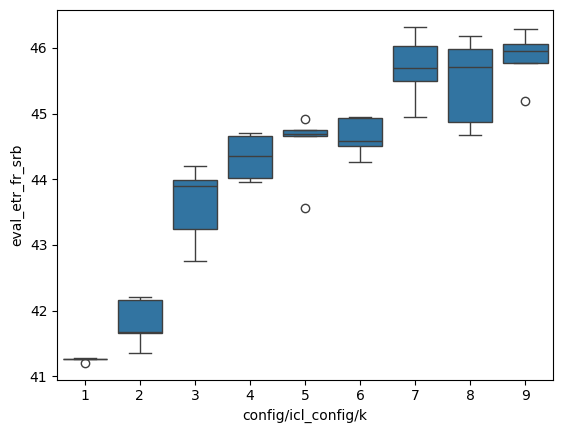

In [272]:
expe = RAGETRFrExpe(model="mistral-7b", method="rag", train_tasks=ETR_FR, step="", expe_dir=ICL_EXPE_DIR)
df = expe.expe_analysis.dataframe()
sns.boxplot(data=df, x="config/icl_config/k", y="eval_etr_fr_srb")

In [ ]:
expe = RAGETRFrExpe(model="llama3-8b", method="zero_shot", train_tasks=ETR_FR, step="", expe_dir=ICL_EXPE_DIR)
df = expe.expe_analysis.dataframe()
sns.boxplot(data=df, y="test_etr_fr_srb")

In [ ]:
df["config/icl_config/prompt_template/shot_template"]

In [ ]:
df[config_columns].eq(best_config)

In [ ]:
df = rag_expes[4].expe_analysis.dataframe()

In [ ]:
df = df.map(lambda x: tuple(x) if isinstance(x, list) else x)

In [ ]:
sns.boxplot(data=df, x="config/icl_config/k", y="eval_etr_fr_srb", dodge=True)